In [52]:
%matplotlib inline
#!pip install rpy2
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import Tensor,optim
import numpy as np
import scipy.io
import pickle
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tqdm
import itertools
from scipy.signal import butter,lfilter, filtfilt, freqz, find_peaks_cwt, medfilt, find_peaks, resample
from trial import Trial
from tqdm import tnrange
import os
import sys
import pandas as pd
import pingouin as pg
np.random.seed(sum(map(ord, "aesthetics")))
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from pymer4.simulate import simulate_lmm, simulate_lm
from pymer4.models import Lm, Lmer, Lm2
from pymer4.utils import result_to_table
from sklearn.preprocessing import StandardScaler
from rpy2.robjects import pandas2ri
pandas2ri.activate()

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, cross_val_score, permutation_test_score, StratifiedKFold
from sklearn.cluster import AffinityPropagation, DBSCAN
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

mpl.rcParams['svg.fonttype'] = 'none'
sns.set_context('poster', font_scale=1.1)

In [53]:
def get_by_animal(trial_list, name):
    return list(filter(lambda trial: trial.name==name,trial_list))

def get_sessions(trial_list):
    sessions = list()
    for trial in trial_list:
        if not trial.session in sessions:
            sessions.append(trial.session)
    sessions.sort()
    return sessions

def get_by_session(trial_list, session):
    return list(filter(lambda trial: trial.session==session,trial_list))

def get_by_date(trial_list, date):
    date = str(date)
    return list(filter(lambda trial: trial.date==date,trial_list))

def get_by_session_type(trial_list, session_type):
    return list(filter(lambda trial: trial.session_type==session_type,trial_list))

def get_performance(trial_list):
    total = 0.0
    for trial in trial_list:
        total += int(trial.correct)
    return total/len(trial_list)

def get_correct_trials(trial_list):
    total = 0.0
    for trial in trial_list:
        if trial.correct == True:
            print(1)
            
        else:
            print(0)

def get_by_delay(trial_list, delay):
    return list(filter(lambda trial: trial.delay_time==delay,trial_list))

def get_by_contrast(trial_list, contrast):
    return list(filter(lambda trial: round(trial.high_count/trial.low_count)==contrast,trial_list))

def get_performance_list(trials):
    sessions = get_sessions(trials)
    performance_list = list()
    for session in sessions:
        performance_list.append(get_performance(get_by_session(trials,session)))
    return performance_list

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def get_inhalation(trial):
    breath = butter_lowpass_filter(trial.breath_profile, cutoff = 10.0, fs = 1000.0, order = 6)
    breath = breath - breath.mean()
    breath = breath / (breath.max() - breath.min()) * 2
    inhalation = np.gradient(breath) < -0.00
    return inhalation.astype(float)

def get_odor_profile_actual(trial):
    kernel = np.load('odor_kernel_50ms.npy')
    pulse_onsets = (np.diff(trial.odor_profile)>0).astype(float)
    pulse_onsets_shifted = np.concatenate((np.zeros((70,)),pulse_onsets,np.zeros(131)))
    odor_profile_actual = np.convolve(pulse_onsets_shifted,kernel,mode='same')
    return odor_profile_actual

def get_full_inhalation(trial):
    breath = butter_lowpass_filter(np.concatenate((trial.pre_breath_profile,trial.breath_profile)), 
                                   cutoff = 10.0, fs = 1000.0, order = 6)
    breath = breath - breath.mean()
    #plt.plot(breath)
    breath = breath / (breath.max() - breath.min()) * 2
    #plt.plot(breath)
    inhalation = np.gradient(breath) < -0.00
    return inhalation.astype(float)

def get_full_inhalation_test(trial):
    breath = butter_lowpass_filter(np.concatenate((trial.pre_breath_profile,trial.breath_profile)), 
                                   cutoff = 10.0, fs = 1000.0, order = 6)
    breath = breath - breath.mean()
    breath = breath / (breath.max() - breath.min()) * 2
    breath[breath>0] = 0
    return -breath

def get_inhaled_odor(trial):
    inhalation = get_inhalation(trial)
    odor_profile = get_odor_profile_actual(trial)
    total_odor = (inhalation[0:odor_profile.size]*odor_profile).sum()
    return total_odor

def get_inhaled_odor_trace(trial):
    sniff_mod_kernel = np.load('inhalation_kernel_fine_weights_active.npy')

    delay_time = trial.delay_time
    sniff = butter_lowpass_filter(trial.breath_profile,10,1000,3)[0:delay_time]
    sniff = (sniff - sniff.mean() +1)/2
    sniff_onset,_ = find_peaks(sniff,distance=150)
    num_sniffs = len(sniff_onset)
    odor_profile_actual = get_odor_profile_actual(trial)
    sniff_norm = np.zeros((num_sniffs,250))
    odor_norm = np.zeros((num_sniffs,250))

    sniff_marks = np.concatenate((sniff_onset[:-1].reshape(-1,1),sniff_onset[1:].reshape(-1,1)),axis=1)
    sniff_durations = np.diff(sniff_marks,axis=1)
    num_sniffs = sniff_marks.shape[0]
    sniff_mod = np.zeros(sniff.shape)
    for i in range(num_sniffs):
        sniff_mod[int(sniff_marks[i,0]):int(sniff_marks[i,1])] = resample(sniff_mod_kernel,int(sniff_durations[i]))
        
    inhaled_odor_trace =  odor_profile_actual[0:delay_time]*sniff_mod
    return inhaled_odor_trace

def get_by_pulses(trial_list, low_pulses, high_pulses):
    return list(filter(lambda trial: (trial.num_pulses>=low_pulses and trial.num_pulses<high_pulses),
                       trial_list))

def get_by_inhaled(trial_list, low, high):
    return list(filter(lambda trial: (get_inhaled_odor(trial)>=low and get_inhaled_odor(trial)<high),
                       trial_list))

def trial_list_filter(trials_list, binsize):

     filt_list = []

     for i in range(len(trials_list)):
          trial = trials_list[i]

          if (trial.delay_time%binsize) != 0:
               pass
          else:
               filt_list.append(trial)

     return filt_list

In [54]:
all_trials_BNPS = pickle.load(open('./Trials/all_trials_BNPS.pickle','rb'))
all_trials_RCS = pickle.load(open("./Trials/all_trials_RCS.pickle",'rb'))
#stark_exc = pickle.load(open('./Trials/Stark_20220223_3.pickle','rb'))
#n_exc = pickle.load(open('./Trials/Natasha_004.pickle','rb'))
merged_dataset = all_trials_BNPS + all_trials_RCS

random_trials_merged = get_by_session_type(merged_dataset, "random")
random_trials_BNPS = get_by_session_type(all_trials_BNPS, "random")
random_trials_RCS = get_by_session_type(all_trials_RCS, "random")

random_trials_BNPS_long = trial_list_filter(random_trials_BNPS, binsize=625)
random_trials_RCS_long = trial_list_filter(random_trials_RCS, binsize=625)
random_trials_all = trial_list_filter(random_trials_merged, binsize=625)


In [55]:
all_trials_BST = pickle.load(open("./Trials/all_trials_BST.pickle",'rb'))
random_trials_BST = get_by_session_type(all_trials_BST, "random")
random_trials_BST_long = trial_list_filter(random_trials_BST, binsize=625)

final_dataset = random_trials_BNPS_long + random_trials_BST_long




In [56]:
savepath = os.getcwd() + '/Figures/test/'
savepath_pdf = os.getcwd() + '/Figures/test/pdf/'
savepath_png = os.getcwd() + '/Figures/test/png/'
savepath_svg = os.getcwd() + '/Figures/test/svg/'

In [57]:
rt_BNPS_5000 = get_by_contrast(get_by_delay(random_trials_BNPS_long, 5000),3)
rt_BNPS_3 = get_by_contrast(random_trials_BNPS_long, 3)
rt_RCS_2500 = get_by_delay(random_trials_RCS_long, 2500)
rt_BNPS_10000 = get_by_delay(random_trials_BNPS_long, 10000)

rt_RCS_1250 = get_by_delay(random_trials_RCS_long, 1250)


all_trials_psy = rt_BNPS_5000 + random_trials_BST_long


In [10]:
test = get_by_contrast(get_by_delay(get_by_animal(random_trials_BNPS_long, 'Natasha'), 5000), 3)
#print(test[1000].high_count)
print(len(test))
# pool_correct_trials = np.zeros((0,))
# pool_high_choices = np.zeros((0,))
# pool_cum_odor = np.zeros((0,))
# for i in range(len(all_correct_trials_list)):
#     pool_correct_trials = np.append(pool_correct_trials,all_correct_trials_list[i])
#     pool_high_choices = np.append(pool_high_choices,all_high_choices_list[i])
#     pool_cum_odor = np.append(pool_cum_odor,all_cum_odor_list[i])

# phigh = np.zeros((num_bins,2))
# performance = np.zeros((num_bins,2))
# bin_counts = np.zeros((num_bins,))
# pulse_bin_ind = np.ceil(pool_cum_odor).astype(np.int)

# for i in range(num_bins):
#     selected = pool_high_choices[pulse_bin_ind==pulse_bins[i]]
#     selected_correct = pool_correct_trials[pulse_bin_ind==pulse_bins[i]]
#     num_selected = len(selected)
#     bin_counts[i] = num_selected
#     phigh[i,0] = selected.mean()
#     phigh[i,1] = 1.96*selected.std()/np.sqrt(num_selected)
#     performance[i,0] = selected_correct.mean()
#     performance[i,1] = 1.96*selected_correct.std()/np.sqrt(num_selected)

1023


In [326]:
if not hasattr(random_trials_BNPS[25200], 'date'):
    print('nana')

In [673]:
np.random.permutation(5000)

array([2861,  811, 1640, ..., 2041,  145, 2276])

In [58]:
class AutoLogReg():
    
    def __init__(self, data, binsize, bins, fixed_bin_size=True, odor_k=True, inh_k=False, full_inh=False, scale=True, shuffle=False):
        
        #super(Model).__init__()
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.data = data
        self.fixed_bin_size = fixed_bin_size
        self._use_odor_kernel = odor_k
        self._use_inh_kernel = inh_k
        self._full_inhalation = full_inh
        self._scale = scale
        self.shuffle = shuffle
        self.bins = bins
        self.binsize = binsize
        self.x_raw = None
        self.sniff = None
        self.df = None
        
    def get_inhaled_odor_trace(self, trial):
        sniff_mod_kernel = np.load('inhalation_kernel_fine_weights_active.npy')

        delay_time = trial.delay_time
        sniff = butter_lowpass_filter(trial.breath_profile,10,1000,3)[0:delay_time]
        self.sniff = (self.sniff - self.sniff.mean() +1)/2
        sniff_onset,_ = find_peaks(self.sniff,distance=150)
        num_sniffs = len(sniff_onset)
        odor_profile_actual = get_odor_profile_actual(trial)
        sniff_norm = np.zeros((num_sniffs,250))
        odor_norm = np.zeros((num_sniffs,250))

        sniff_marks = np.concatenate((sniff_onset[:-1].reshape(-1,1),sniff_onset[1:].reshape(-1,1)),axis=1)
        sniff_durations = np.diff(sniff_marks,axis=1)
        num_sniffs = sniff_marks.shape[0]
        sniff_mod = np.zeros(self.sniff.shape)
        for i in range(num_sniffs):
            sniff_mod[int(sniff_marks[i,0]):int(sniff_marks[i,1])] = resample(sniff_mod_kernel,int(sniff_durations[i]))
        inhaled_odor_trace =  odor_profile_actual[0:trial.delay_time]*sniff_mod
        return inhaled_odor_trace
             
    def compiler_df(self): #def autologreg(self, nrounds, binsize):

        results_list=list()
        total_trials = get_by_session_type(self.data, 'random')
        
        for i_trial in range(len(total_trials)):
            trial = total_trials[i_trial]
            dt=0
            pre_time = trial.refract_time
            self.sniff = butter_lowpass_filter(trial.breath_profile,10,1000,3)[0:trial.delay_time]

            if self._use_odor_kernel:
                self.x_raw = get_odor_profile_actual(trial)[0:trial.delay_time] #allocates odor pulse 
                                        #profile for each trial into x_raw
                    
            elif self._use_inh_kernel:

                self.x_raw = self.get_inhaled_odor_trace(trial)
                    
            elif self._full_inhalation:
                self.x_raw = get_full_inhalation(trial)[(
                    pre_time+dt):(pre_time+dt+trial.delay_time)] * get_odor_profile_actual(trial)[0:trial.delay_time]
                
            if self.shuffle == True:
                self.x_raw_shuffled = np.zeros(self.x_raw.shape)
                ind_array = np.random.permutation(trial.delay_time)
                self.x_raw_shuffled = self.x_raw[ind_array]
                self.x_raw = self.x_raw_shuffled
            
            if self.fixed_bin_size==True:

                self.new_x_raw = self.x_raw.reshape(int(trial.delay_time/self.binsize), self.binsize).mean(axis=1).squeeze() #mean(axis=1).squeeze()

            if self.fixed_bin_size==False:

                self.new_x_raw = self.x_raw.reshape(self.bins, int(trial.delay_time/self.bins)).mean(axis=1).squeeze() #.mean(axis=1).squeeze()

            keys = []
            for i in range(len(self.new_x_raw)):
                keys.append('Pulses_bin_'+str(i+1))
            
            pulse_dicts = {}
            for i, j in zip(keys, range(len(self.new_x_raw))):
                pulse_dicts[i] = self.new_x_raw[j]

            if not hasattr(trial, 'date'):
                trial_date = '20220410'
        
            else:
                trial_date = trial.date

            result_row_1 = {'Animal': trial.name,
                'Window':trial.delay_time,
                'Date':trial_date,
                'Session_name': str(trial.name+trial_date),
                'Difficulty':np.round(trial.high_count/trial.low_count),#.astype(str),
                'Session': trial.session,
                'Trial': trial.number,
                'Reward_side': trial.reward_side,
                'Choice': trial.lick_side.astype(int),
                'Total Pulse': np.ceil(trial.odor_profile.sum(axis=0)/5000).astype(int)
            }
            result_row_1.update(pulse_dicts)
            results_list.append(result_row_1)
          
        self.df = pd.DataFrame(results_list)
        max_delay = self.df['Window'].max()
        #print(max_delay)
        self.df['Session'] = self.df['Session'].astype(str)

        scaler = StandardScaler()
        columns_to_scale = []

        if self.fixed_bin_size==True:
            for i in range(int(max_delay/self.binsize)):
                columns_to_scale.append('Pulses_bin_'+str(i+1))

        if self.fixed_bin_size==False:
            for i in range(self.bins):
                columns_to_scale.append('Pulses_bin_'+str(i+1))

        if self._scale==True:

            scaler.fit(self.df[columns_to_scale])
            scaled_columns = scaler.transform(self.df[columns_to_scale])
            self.df[columns_to_scale] = scaled_columns

        return self.df

In [698]:
from sklearn.metrics import accuracy_score

In [62]:
df_all

,Animal,Window,Date,Session_name,Difficulty,Session,Trial,Reward_side,Choice,Total Pulse,Pulses_bin_1,Pulses_bin_2,Pulses_bin_3,Pulses_bin_4,Pulses_bin_5
0,Banner,5000,20220305,Banner20220305,3.0,1,0,1,1,18,0.210333,0.195853,2.120527,1.477172,2.115012
1,Banner,5000,20220305,Banner20220305,3.0,1,1,1,0,9,0.228862,-0.092779,-0.199678,-1.118015,1.486702
2,Banner,5000,20220305,Banner20220305,3.0,1,2,1,1,18,2.212338,2.137104,0.826543,0.166982,0.832751
3,Banner,5000,20220305,Banner20220305,3.0,1,3,0,0,7,-0.432296,-1.128824,0.179551,-1.118015,1.486702
4,Banner,5000,20220305,Banner20220305,3.0,1,4,0,0,3,-0.432296,-1.128824,-0.467441,-0.475516,-1.129102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20093,Tabby,5000,20190519,Tabby20190519,3.0,0,250,1,0,12,-1.093455,0.177547,2.140353,1.432292,-0.475151
20094,Tabby,5000,20190519,Tabby20190519,3.0,0,251,0,0,4,-0.563622,-0.999083,-0.467441,0.166982,-1.129102
20095,Tabby,5000,20190519,Tabby20190519,3.0,0,252,0,0,3,-1.093455,-0.834869,-0.111617,-0.475516,-1.129102
20096,Tabby,5000,20190519,Tabby20190519,3.0,0,253,1,0,19,2.212338,2.787613,1.476186,1.451134,-1.128241


In [84]:
def df_filter(df, delayt, binsize):

    new_df = df.loc[df['Window'] == delayt]
    vars = list(new_df.columns[-5:]) #[7:])
    f_vars = vars[:int(delayt/binsize)]
    
    return new_df, f_vars

def formula_maker(listvar, pred_choice=True, pred_id=False, interaction=True):

    if pred_choice ==  True:
        y = str('Choice ~ ')

    if pred_id == True:
        y = str('Reward_side ~ ')

    separator = '+'
    lin_pred_alt = str('I(') + separator.join(listvar)
    lin_pred = str('(') + separator.join(listvar)
    int_term = str(') * Difficulty + ')
    ranef = str('(') + separator.join(listvar) + str('||Animal/Session_name)') #+ (Window|Animal) :Date str('(1|Animal)')
    ranef_one_beta = str('(I(') + separator.join(listvar) + str(')||Animal/Session_name)')

    if interaction == False:
        y = y
        separator = '+'
        lin_pred_alt = str('I(') + separator.join(listvar) + str(')')
        lin_pred = separator.join(listvar)
        int_term = str(' + ')
        ranef = str('(') + separator.join(listvar) + str('||Animal/Session_name)') #+ (Window|Animal) :Date str('(1|Animal)')
        ranef_one_beta = str('(I(') + separator.join(listvar) + str(')||Animal/Session_name)')

    formula_sep =  (y+lin_pred+int_term+ranef)
    formula_one_beta = (y+lin_pred_alt+int_term+ranef_one_beta)
    
    return formula_sep, formula_one_beta

def model_fit_compare(df, f1, f2, listvar, factor='Difficulty'):

    levels = list(np.roll(df[factor].unique(), -1).astype(str))
    #print('This are the levels of', factor, levels)

    m_varying_coefs = Lmer(formula = f1, family='binomial', data = df)
    m_single_coef = Lmer(formula = f2, family='binomial', data = df)

    if len(levels) < 2:
        m_varying_coefs.fit(summarize=True, verbose=True, control="optimizer='bobyqa'")
        m_single_coef.fit(summarize=True, verbose=True, control="optimizer='bobyqa'")
        
    else:

        m_varying_coefs.fit(factors={factor: levels}, summarize=True, 
                            ordered=True, verbose=True, control="optimizer='bobyqa'")
        m_single_coef.fit(factors={factor: levels}, summarize=True, 
                        ordered=True, verbose=True, control="optimizer='bobyqa'")

    #print(len())
        
    # pred_vc = m_varying_coefs.predict(df, skip_data_checks=True, verify_predictions=False)
    # pred_sc = m_single_coef.predict(df, skip_data_checks=True, verify_predictions=False)

    # binary_preds_vc = [1 if prob>=0.5 else 0 for prob in pred_vc]
    # binary_preds_sc = [1 if prob>=0.5 else 0 for prob in pred_sc]

    mvc_loglik = m_varying_coefs.logLike
    msc_loglik = m_single_coef.logLike

    # actual_labels = df['Choice'].values

    # acc_vc = accuracy_score(actual_labels,binary_preds_vc)
    # acc_sc = accuracy_score(actual_labels,binary_preds_sc)
    
    statistic = -2*(msc_loglik-mvc_loglik)

    print(len(m_varying_coefs.coefs['Estimate']), len(m_single_coef.coefs['Estimate']))
    fixed_effects_dif = len(m_varying_coefs.coefs['Estimate']) - len(m_single_coef.coefs['Estimate']) #m_varying_coefs.coefs, , m_single_coef.coefs
    var_coefs_random = sum([len(v) for v in m_varying_coefs.ranef_var.values])
    single_coef_random = sum([len(v) for v in m_single_coef.ranef_var.values])
    print(m_varying_coefs.ranef_var)
    print(var_coefs_random, single_coef_random)
    dof = fixed_effects_dif + (var_coefs_random - single_coef_random)
    print(dof)
    p_val = scipy.stats.chi2.sf(statistic, dof) #(len(m_varying_coefs.coefs)-len(m_single_coef.coefs))
    
    m_vc_confints = m_varying_coefs.confint(listvar)
    lower_limit_vc = m_vc_confints['2.5 %']
    upper_limit_vc = m_vc_confints['97.5 %']

    # print(f"Accuracy on training data of mult coef: {acc_vc}")
    # print(f"Accuracy on training data of mult coef: {acc_sc}")


    m_sc_confints = m_single_coef.confint()
    m_sc_confints = m_sc_confints.dropna()
    lower_limit_sc = m_sc_confints['2.5 %'][1]
    upper_limit_sc = m_sc_confints['97.5 %'][1]

    mvc_df = result_to_table(m_varying_coefs)
    msc_df = result_to_table(m_single_coef)

    print(m_varying_coefs.factors)

    betas = mvc_df['b'][:len(listvar)]
    single_beta = msc_df['b'][0]/msc_df['b'][0].max()
    fig = plt.figure()
    plt.plot(range(len(listvar)), betas/betas.max())
    plt.fill_between(range(len(listvar)), upper_limit_vc/betas.max(), lower_limit_vc/betas.max(), alpha=0.2)
    plt.axhline(single_beta, color='r')
    plt.fill_between(range(len(listvar)), upper_limit_sc/msc_df['b'][0].max(), lower_limit_sc/msc_df['b'][0].max(), alpha=0.2)
    plt.ylim(0,1.5)
    plt.xlim(0,len(listvar)-1)
    ymin, ymax = plt.ylim()
    plt.xticks(np.arange(len(listvar)), np.arange(1,len(listvar)+1))
    plt.text(0.1,ymin, 'p-value: '+str(p_val))
    plt.xlabel('Time Bin')
    plt.ylabel('Coefficient')
    sns.despine(offset=10)

    #this is just for Venki:
    vc_dict = {'coef': betas, 'upper_limit_ci': upper_limit_vc, 'lower_limit_ci': lower_limit_vc}
    sc_dict = {'coef': msc_df['b'], 'upper_limit_ci': upper_limit_sc, 'lower_limit_ci': lower_limit_sc}
    

    return fig, p_val, mvc_df, msc_df, vc_dict, sc_dict

In [458]:
df_all[df_all['Animal'] == 'Banner']['Date'].unique()

array(['20220305', '20220313', '20220314', '20220315', '20220317',
       '20220318', '20220319', '20220321', '20220322', '20220323',
       '20220324', '20220325', '20220326', '20220328', '20220330',
       '20220331', '20220401', '20220404', '20220405', '20220406',
       '20220407', '20220408', '20220410', '20220411', '20220412',
       '20220413', '20220414', '20220415', '20220418', '20220419',
       '20220420', '20220421', '20220422', '20220424', '20220425',
       '20220427', '20220428', '20220429', '20220503', '20220504',
       '20220506', '20220508', '20220509', '20220510', '20220511',
       '20220512'], dtype=object)

In [60]:
inh_kernel_5_bins = AutoLogReg(all_trials_psy, binsize=625, bins = 5, 
                            fixed_bin_size=False, odor_k=True, inh_k=False, full_inh=False, scale=True, shuffle=False)
df_all = inh_kernel_5_bins.compiler_df()



In [61]:
df_all

,Animal,Window,Date,Session_name,Difficulty,Session,Trial,Reward_side,Choice,Total Pulse,Pulses_bin_1,Pulses_bin_2,Pulses_bin_3,Pulses_bin_4,Pulses_bin_5
0,Banner,5000,20220305,Banner20220305,3.0,1,0,1,1,18,0.210333,0.195853,2.120527,1.477172,2.115012
1,Banner,5000,20220305,Banner20220305,3.0,1,1,1,0,9,0.228862,-0.092779,-0.199678,-1.118015,1.486702
2,Banner,5000,20220305,Banner20220305,3.0,1,2,1,1,18,2.212338,2.137104,0.826543,0.166982,0.832751
3,Banner,5000,20220305,Banner20220305,3.0,1,3,0,0,7,-0.432296,-1.128824,0.179551,-1.118015,1.486702
4,Banner,5000,20220305,Banner20220305,3.0,1,4,0,0,3,-0.432296,-1.128824,-0.467441,-0.475516,-1.129102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20093,Tabby,5000,20190519,Tabby20190519,3.0,0,250,1,0,12,-1.093455,0.177547,2.140353,1.432292,-0.475151
20094,Tabby,5000,20190519,Tabby20190519,3.0,0,251,0,0,4,-0.563622,-0.999083,-0.467441,0.166982,-1.129102
20095,Tabby,5000,20190519,Tabby20190519,3.0,0,252,0,0,3,-1.093455,-0.834869,-0.111617,-0.475516,-1.129102
20096,Tabby,5000,20190519,Tabby20190519,3.0,0,253,1,0,19,2.212338,2.787613,1.476186,1.451134,-1.128241


In [13]:
model = LogisticRegression()

output = list()
list_of_sessions = df_all['Session_name'].unique()
#print(list_of_sessions)
pulse_cols = list(df_all.columns[11:])
list_of_cols = list()
for i in range(9):
    list_of_cols.append(pulse_cols[:i+1])

for beh_session in list_of_sessions:
    df_x = df_all.loc[df_all['Session_name']==beh_session]
    y = df_x['Choice'].values

    for colx in list_of_cols:
    # Combine all time bins (early, mid, late) into a single feature matrix
        X = df_x[colx].values  # Feature matrix
        # Fit the model
        model.fit(X, y)

        skf = StratifiedKFold(n_splits=5)

        # Perform permutation test score
        score, permutation_scores, p_value = permutation_test_score(
            model, X, y, cv=skf, n_permutations=1000, scoring="accuracy", n_jobs=-1)

        # Number of parameters (including intercept)
        # n_params = len(model.coef_.flatten()) + 1  # coefficients + intercept
        # Predicted probabilities for log-likelihood calculation
        # y_pred_prob = model.predict_proba(X)
        # Calculate log-likelihood
        # log_likelihood = -log_loss(y, y_pred_prob, normalize=False)
        # # Compute AIC: 2k - 2 * log-likelihood
        # aic = 2 * n_params - 2 * log_likelihood
        # #print(f"AIC: {aic}")
        
        # Store the coefficients for each time bin
        output.append({
            'Session_name': beh_session,
            'Bins': len(colx),
            'real_accuracy': score,
            'perm_accuracy': np.median(permutation_scores),
            'p_value': p_value})
            

pulses_df_cum = pd.DataFrame(output)
pulses_df_cum
    # for sess in list_of_sessions:
    #     print(sess)
    #     df_x = df_all.loc[df_all['Session_name']==sess]
        

KeyboardInterrupt: 

(0.5, 1.0)

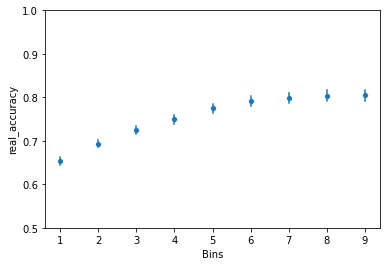

In [53]:
sns.lineplot(data=pulses_df_cum, x='Bins', y='real_accuracy', linestyle='', marker='o', err_style='bars')
plt.ylim(0.5,1)


In [49]:
model = LogisticRegression()

output = list()
list_of_sessions = df_all['Session_name'].unique()
#print(list_of_sessions)
pulse_cols = list(df_all.columns[11:])
list_of_cols = list()
for i in range(9):
    list_of_cols.append(pulse_cols[i])

for beh_session in list_of_sessions:
    df_x = df_all.loc[df_all['Session_name']==beh_session]
    y = df_x['Choice'].values

    for c,colx in zip(np.arange(1,10),list_of_cols):
    # Combine all time bins (early, mid, late) into a single feature matrix
        #print(c, colx)
        X = df_x[colx].values.reshape(-1, 1)
        #X = X.reshape(1, -1)  # Feature matrix
        # Fit the model
        model.fit(X, y)

        skf = StratifiedKFold(n_splits=5)

        # Perform permutation test score
        score, permutation_scores, p_value = permutation_test_score(
            model, X, y, cv=skf, n_permutations=1000, scoring="accuracy", n_jobs=-1)

        # Number of parameters (including intercept)
        # n_params = len(model.coef_.flatten()) + 1  # coefficients + intercept
        # Predicted probabilities for log-likelihood calculation
        # y_pred_prob = model.predict_proba(X)
        # Calculate log-likelihood
        # log_likelihood = -log_loss(y, y_pred_prob, normalize=False)
        # # Compute AIC: 2k - 2 * log-likelihood
        # aic = 2 * n_params - 2 * log_likelihood
        # #print(f"AIC: {aic}")
        
        # Store the coefficients for each time bin
        output.append({
            'Session_name': beh_session,
            'Bins': c,
            'real_accuracy': score,
            'perm_accuracy': np.mean(permutation_scores),
            'p_value': p_value})
            

pulses_df_ind = pd.DataFrame(output)
pulses_df_ind
    # for sess in list_of_sessions:
    #     print(sess)
    #     df_x = df_all.loc[df_all['Session_name']==sess]
        

,Session_name,Bins,real_accuracy,perm_accuracy,p_value
0,Bengal20190419,1,0.626286,0.567307,0.001998
1,Bengal20190419,2,0.638122,0.566393,0.000999
2,Bengal20190419,3,0.646367,0.566906,0.000999
3,Bengal20190419,4,0.678367,0.567217,0.000999
4,Bengal20190419,5,0.650449,0.566625,0.000999
...,...,...,...,...,...
508,Tabby20190519,5,0.737255,0.610047,0.000999
509,Tabby20190519,6,0.690196,0.610035,0.000999
510,Tabby20190519,7,0.713725,0.610031,0.000999
511,Tabby20190519,8,0.694118,0.609902,0.000999


(0.5, 1.0)

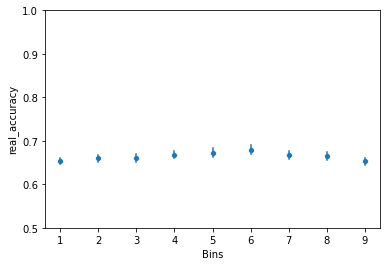

In [51]:
sns.lineplot(data=pulses_df_ind, x='Bins', y='real_accuracy', linestyle='', marker='o', err_style='bars')
plt.ylim(0.5,1)

In [54]:
model = LogisticRegression()

output = list()
list_of_sessions = df_all['Session_name'].unique()
#print(list_of_sessions)
pulse_cols = list(df_all.columns[11:])
list_of_cols = list()
for i in range(9):
    list_of_cols.append(pulse_cols[:i+1])

for beh_session in list_of_sessions:
    df_x = df_all.loc[df_all['Session_name']==beh_session]
    y = df_x['Reward_side'].values

    for colx in list_of_cols:
    # Combine all time bins (early, mid, late) into a single feature matrix
        X = df_x[colx].values  # Feature matrix
        # Fit the model
        model.fit(X, y)

        skf = StratifiedKFold(n_splits=5)

        # Perform permutation test score
        score, permutation_scores, p_value = permutation_test_score(
            model, X, y, cv=skf, n_permutations=1000, scoring="accuracy", n_jobs=-1)

        # Number of parameters (including intercept)
        # n_params = len(model.coef_.flatten()) + 1  # coefficients + intercept
        # Predicted probabilities for log-likelihood calculation
        # y_pred_prob = model.predict_proba(X)
        # Calculate log-likelihood
        # log_likelihood = -log_loss(y, y_pred_prob, normalize=False)
        # # Compute AIC: 2k - 2 * log-likelihood
        # aic = 2 * n_params - 2 * log_likelihood
        # #print(f"AIC: {aic}")
        
        # Store the coefficients for each time bin
        output.append({
            'Session_name': beh_session,
            'Bins': len(colx),
            'real_accuracy': score,
            'perm_accuracy': np.median(permutation_scores),
            'p_value': p_value})
            

pulses_df_cum_tt = pd.DataFrame(output)
pulses_df_cum_tt
    # for sess in list_of_sessions:
    #     print(sess)
    #     df_x = df_all.loc[df_all['Session_name']==sess]

,Session_name,Bins,real_accuracy,perm_accuracy,p_value
0,Bengal20190419,1,0.711020,0.501878,0.000999
1,Bengal20190419,2,0.823510,0.502163,0.000999
2,Bengal20190419,3,0.871673,0.501796,0.000999
3,Bengal20190419,4,0.875755,0.501878,0.000999
4,Bengal20190419,5,0.919755,0.501918,0.000999
...,...,...,...,...,...
508,Tabby20190519,5,0.882353,0.545098,0.000999
509,Tabby20190519,6,0.898039,0.541176,0.000999
510,Tabby20190519,7,0.913725,0.541176,0.000999
511,Tabby20190519,8,0.960784,0.537255,0.000999


(0.5, 1.0)

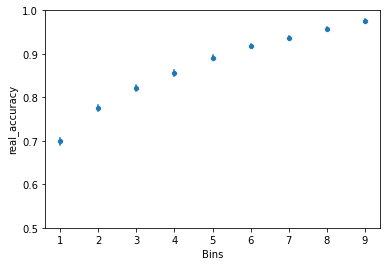

In [55]:
sns.lineplot(data=pulses_df_cum_tt, x='Bins', y='real_accuracy', linestyle='', marker='o', err_style='bars')
plt.ylim(0.5,1)


In [58]:
model = LogisticRegression()

output = list()
list_of_sessions = df_all['Session_name'].unique()
#print(list_of_sessions)
pulse_cols = list(df_all.columns[11:])
list_of_cols = list()
for i in range(9):
    list_of_cols.append(pulse_cols[i])

for beh_session in list_of_sessions:
    df_x = df_all.loc[df_all['Session_name']==beh_session]
    y = df_x['Reward_side'].values

    for c,colx in zip(np.arange(1,10),list_of_cols):
    # Combine all time bins (early, mid, late) into a single feature matrix
        #print(c, colx)
        X = df_x[colx].values.reshape(-1, 1)
        #X = X.reshape(1, -1)  # Feature matrix
        # Fit the model
        model.fit(X, y)

        skf = StratifiedKFold(n_splits=5)

        # Perform permutation test score
        score, permutation_scores, p_value = permutation_test_score(
            model, X, y, cv=skf, n_permutations=1000, scoring="accuracy", n_jobs=-1)

        # Number of parameters (including intercept)
        # n_params = len(model.coef_.flatten()) + 1  # coefficients + intercept
        # Predicted probabilities for log-likelihood calculation
        # y_pred_prob = model.predict_proba(X)
        # Calculate log-likelihood
        # log_likelihood = -log_loss(y, y_pred_prob, normalize=False)
        # # Compute AIC: 2k - 2 * log-likelihood
        # aic = 2 * n_params - 2 * log_likelihood
        # #print(f"AIC: {aic}")
        
        # Store the coefficients for each time bin
        output.append({
            'Session_name': beh_session,
            'Bins': c,
            'real_accuracy': score,
            'perm_accuracy': np.mean(permutation_scores),
            'p_value': p_value})
            
pulses_df_ind_tt = pd.DataFrame(output)
pulses_df_ind_tt
    # for sess in list_of_sessions:
    #     print(sess)
    #     df_x = df_all.loc[df_all['Session_name']==sess]
        

,Session_name,Bins,real_accuracy,perm_accuracy,p_value
0,Bengal20190419,1,0.711020,0.499924,0.000999
1,Bengal20190419,2,0.722612,0.498991,0.000999
2,Bengal20190419,3,0.699020,0.498226,0.000999
3,Bengal20190419,4,0.730531,0.501628,0.000999
4,Bengal20190419,5,0.654449,0.498482,0.000999
...,...,...,...,...,...
508,Tabby20190519,5,0.733333,0.564871,0.000999
509,Tabby20190519,6,0.686275,0.565408,0.000999
510,Tabby20190519,7,0.721569,0.565008,0.000999
511,Tabby20190519,8,0.721569,0.565216,0.000999


(0.5, 1.0)

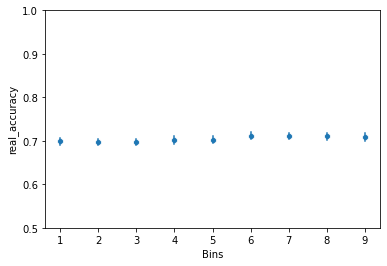

In [59]:
sns.lineplot(data=pulses_df_ind_tt, x='Bins', y='real_accuracy', linestyle='', marker='o', err_style='bars')
plt.ylim(0.5,1)

In [569]:
df_all['group_num'] = df_all.groupby(['Animal','Date', 'Session', 'Window', 'Difficulty']).ngroup()
df_all['Session_num'] = df_all.groupby(['Animal', 'Window', 'Difficulty'])['group_num'].rank(method='dense').astype(int)-1
df_all[(df_all['Session_num']==11) & (df_all['Animal']=='Natasha')]
col_to_pop = df_all.pop('Session_num')
df_all.insert(5, 'Session_num', col_to_pop)
df_reorganized = df_all.drop(df_all.columns[-6:], axis=1)
df_reorganized['Date'] = df_reorganized['Date'].replace({'20241231':'20220410'})

a_df = df_reorganized.loc[(df_reorganized['Window']==5000) & (df_reorganized['Difficulty']==2.0) & (df_reorganized['Session_num']==0)]
a_df[880:]

,Animal,Window,Date,Difficulty,Session,Session_num,Trial,Reward_side,Choice,Total Pulse
36450,Stark,5000,20220328,2.0,0,0,300,1,1,14
36451,Stark,5000,20220328,2.0,0,0,301,0,0,4
36452,Stark,5000,20220328,2.0,0,0,302,0,0,6
36453,Stark,5000,20220328,2.0,0,0,303,1,1,14
36454,Stark,5000,20220328,2.0,0,0,304,0,0,4
36455,Stark,5000,20220328,2.0,0,0,305,0,0,8
36456,Stark,5000,20220328,2.0,0,0,306,1,1,10
36457,Stark,5000,20220328,2.0,0,0,307,0,0,5
36458,Stark,5000,20220328,2.0,0,0,308,0,0,5
36459,Stark,5000,20220328,2.0,0,0,309,1,1,9


In [662]:
df_all['Difficulty'].unique()

array([3.])

In [349]:
check = df_all.loc[(df_all['Date']=='20190517') & (df_all['Animal']=='Tabby')]
check.head(41)

,Animal,Window,Date,Difficulty,Session,Trial,Reward_side,Choice,Total Pulse,Pulses_bin_1,Pulses_bin_2,Pulses_bin_3,Pulses_bin_4,Pulses_bin_5
13173,Tabby,5000,20190517,3.0,0,0,0,1,3,-1.092297,-1.118593,-0.473965,-1.109962,-0.475904
13174,Tabby,5000,20190517,3.0,0,1,0,0,4,-0.445920,-0.472595,0.158843,-1.109433,-1.122048
13175,Tabby,5000,20190517,3.0,0,2,1,1,17,1.790173,-0.123386,1.411503,0.796893,1.445887
13176,Tabby,5000,20190517,3.0,0,3,0,0,4,-1.092297,-1.118593,-0.473965,-0.479175,0.161919
13177,Tabby,5000,20190517,3.0,0,4,1,1,19,1.493210,1.465399,1.037921,1.799758,0.803903
13178,Tabby,5000,20190517,3.0,0,5,1,1,19,2.131652,1.473330,1.060531,1.146451,0.803903
13179,Tabby,5000,20190517,3.0,0,6,0,1,6,-1.092297,-1.118593,0.792715,-0.479175,0.161919
13180,Tabby,5000,20190517,3.0,0,7,0,0,3,-0.445920,-0.486089,-1.094075,-1.109962,-0.480064
13181,Tabby,5000,20190517,3.0,0,8,0,1,4,-1.092297,-1.118593,0.792715,-0.479175,-1.122048
13182,Tabby,5000,20190517,3.0,0,9,0,0,4,0.200457,-1.118593,-0.474910,-0.531907,-1.067422


In [627]:
df_all['Total Signal'] = df_all['Pulses_bin_1'] + df_all['Pulses_bin_2']
df_all['Rel1'] = df_all['Pulses_bin_1']/df_all['Total Signal']*100
df_all['Rel2'] = df_all['Pulses_bin_2']/df_all['Total Signal']*100
df_all['Correct'] = (df_all['Reward_side']==df_all['Choice'])*1



balance_condition = [(df_all['Rel1']>80), (df_all['Rel1']>20) & (df_all['Rel1']<80), (df_all['Rel1']<20)]
values = [1, 0, 2]

df_all['Balance'] = np.select(balance_condition, values)#df_all.loc[(df_all['Rel1']>20) & (df_all['Rel1']<80)].astype(int)
#df_all['High Start'] = (df_all['Rel1']>80).astype(int)
df_all


,Animal,Window,Date,Difficulty,Session,Tial,Reward_side,Choice,Total Pulse,Pulses_bin_1,Pulses_bin_2,Total Signal,Rel1,Rel2,Correct,Balance
0,Banner,5000,20220305,3.0,1,0,1,1,18,0.120276,0.159581,0.279857,42.977763,57.022237,1,0
1,Banner,5000,20220305,3.0,1,1,1,0,9,0.077429,0.062500,0.139929,55.334723,44.665277,0,0
2,Banner,5000,20220305,3.0,1,2,1,1,18,0.202119,0.077738,0.279857,72.222222,27.777778,1,0
3,Banner,5000,20220305,3.0,1,3,0,0,7,0.031095,0.077738,0.108833,28.571429,71.428571,1,0
4,Banner,5000,20220305,3.0,1,4,0,0,3,0.031095,0.015548,0.046643,66.666667,33.333333,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20093,Tabby,5000,20190519,3.0,0,250,1,0,12,0.046643,0.139929,0.186572,25.000000,75.000000,0,0
20094,Tabby,5000,20190519,3.0,0,251,0,0,4,0.015548,0.046643,0.062191,25.000000,75.000000,1,0
20095,Tabby,5000,20190519,3.0,0,252,0,0,3,0.031095,0.015548,0.046643,66.666667,33.333333,1,0
20096,Tabby,5000,20190519,3.0,0,253,1,0,19,0.227179,0.068225,0.295405,76.904417,23.095583,0,0


In [647]:
# sns.scatterplot(x='Total Pulse', y='Rel1', data=df_all, alpha=0.2)
# plt.ylabel('Percentage of odor information in first half')

df_high = df_all.loc[df_all['Total Pulse']>=9]
df_low = df_all.loc[df_all['Total Pulse']<=8]

df_analysis = df_high

#observed_diff = df_analysis[df_analysis['Balance']==1]['Correct'].mean() - df_analysis[df_analysis['High Start']==1]['Correct'].mean()
#print(df_analysis[df_analysis['Balance']==1]['Correct'].mean())
#print(df_analysis[df_analysis['High Start']==1]['Correct'].mean())

#df_analysis


0.479


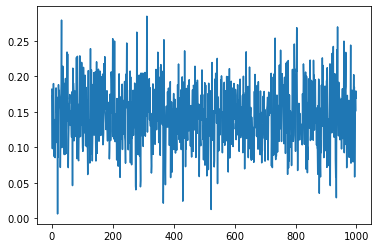

In [620]:
def bootstrap_proportions_diff(df, n_iterations=2000):
    #weights = df['Correct'].value_counts(normalize=True).reindex(df['Correct']).values
    bootstrap_diffs = []
    for _ in range(n_iterations):
        sample = df.sample(n=len(df), replace=True)#, weights=weights)
        #print(len(sample))
        prop_A_boot = sample[sample['Balance'] == 1]['Correct'].mean()
        prop_B_boot = sample[sample['High Start'] == 1]['Correct'].mean()
        bootstrap_diffs.append(prop_A_boot - prop_B_boot)
    return np.array(bootstrap_diffs)

n_iter = 1000
bootstrap_diffs = bootstrap_proportions_diff(df_analysis, n_iter)

# Calculate p-value (two-sided test)
p_value = np.mean(np.abs(bootstrap_diffs) >= np.abs(observed_diff))
print(p_value)
plt.plot(bootstrap_diffs)

In [644]:
df_analysis = df_analysis.loc[(df_analysis['Balance']<2)]

In [645]:
#Using statmodels:
import statsmodels.stats.api as sms
bursty = df_analysis[df_analysis['Balance'] == 1]['Correct']
non_bursty = df_analysis[df_analysis['Balance'] == 0]['Correct']

# Perform the bootstrap to compare means
# bs = sms.CompareMeans(sms.DescrStatsW(bursty), sms.DescrStatsW(non_bursty))
# bootstrap_result = bs.bootstrap(10000, usevar='unequal')

# # Extract confidence interval and observed difference
# observed_diff = bs.mean_diff
# ci_lower, ci_upper = bootstrap_result[0]

# print(f"Observed difference in proportions: {observed_diff}")
# print(f"95% Confidence Interval: ({ci_lower}, {ci_upper})")


In [646]:
def diff_means(bursty, non_bursty):
    return bursty.mean() - non_bursty.mean()

# Perform the bootstrap to calculate the confidence interval
boot_bursty = pg.compute_bootci(bursty, func='mean', n_boot=1000)
boot_non_bursty = pg.compute_bootci(non_bursty, func='mean', n_boot=1000)

# Calculate the observed difference
observed_diff = diff_means(bursty, non_bursty)

# Calculate the bootstrapped confidence interval for the difference
diffs = [diff_means(np.random.choice(bursty, size=len(bursty), replace=True), 
                    np.random.choice(non_bursty, size=len(non_bursty), replace=True))
         for _ in range(10000)]

ci_lower, ci_upper = np.percentile(diffs, [2.5, 97.5])

p_value = np.mean(np.abs(bootstrap_diffs) >= np.abs(observed_diff))


# Print the results
print(f"Observed difference in proportions: {observed_diff}")
print(f"95% Confidence Interval: ({ci_lower}, {ci_upper})")
print(p_value)

Observed difference in proportions: -0.14423831545356658
95% Confidence Interval: (-0.22735938736395603, -0.06333466837032523)
0.488


In [207]:
results_array = np.zeros((3,3))

results_array[0,0] = df_balanced['Correct'].mean()
results_array[0, 1:], bt_b = pg.compute_bootci(x=df_balanced['Correct'], func='mean', method='cper', confidence=.95, n_boot = 500, decimals = 3, seed=123, return_dist=True)
results_array[1,0] = df_imbalanced_hstart['Correct'].mean()
results_array[1, 1:], bt_h = pg.compute_bootci(x=df_imbalanced_hstart['Correct'], func='mean', method='cper', confidence=.95, n_boot = 500, decimals = 3, seed=123, return_dist=True)
results_array[2,0] = df_imbalanced_lstart['Correct'].mean()
results_array[2, 1:], bt_l = pg.compute_bootci(x=df_imbalanced_lstart['Correct'], func='mean', method='cper', confidence=.95, n_boot = 500, decimals = 3, seed=123, return_dist=True)

results_array


array([[0.8383936 , 0.83      , 0.847     ],
       [0.73710904, 0.71      , 0.762     ],
       [0.79927339, 0.775     , 0.821     ]])

<AxesSubplot:>

/Users/boero/opt/anaconda3/envs/all_behavior/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 46.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


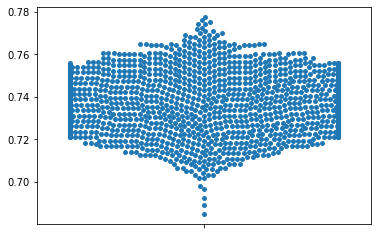

In [166]:
sns.swarmplot(bt_h)

In [195]:
a= np.asarray([1,2,3,4,5,6,7,8,9])#zeros((5))
b= np.asarray([101,102,103,104,105,106,107,108,109])
pg.ttest(a,b)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-77.459667,16,two-sided,4.921640e-22,"[-102.74, -97.26]",36.514837,1.648e+18,1.0


In [210]:
pg.mwu(a, b)#alternative='less', correction='auto')

,U-val,alternative,p-val,RBC,CLES
MWU,0.0,two-sided,5.672543e-165,1.0,0.0


In [209]:
b = np.asarray(bt_b)
a = np.asarray(bt_h)

print(np.var(b))

1.8815370167396662e-05


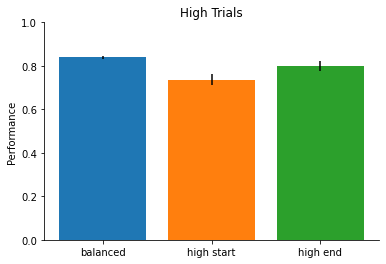

In [121]:
for i in range(3):
    plt.bar(x=i, height=results_array[i,0], yerr=results_array[i,2]-results_array[i,0])

plt.xticks(np.arange(3), ['balanced', 'high start', 'high end'])
plt.title('High Trials')
plt.ylabel('Performance')
plt.ylim(0,1)
sns.despine()
plt.show()

In [122]:
df_balanced_low = df_all.loc[(df_all['Total Pulse'] < 8) & (df_all['Rel1'] < 80)  & (df_all['Rel1'] > 20)]
df_imbalanced_low_l_end = df_all.loc[(df_all['Total Pulse'] < 8) & (df_all['Rel1'] > 80)]
df_imbalanced_low_h_end = df_all.loc[(df_all['Total Pulse'] < 8) & (df_all['Rel1'] < 20)]

In [123]:
results_array_low = np.zeros((3,3))

results_array_low[0,0] = df_balanced_low['Correct'].mean()
results_array_low[0, 1:] = pg.compute_bootci(x=df_balanced_low['Correct'], func='mean', method='cper', confidence=.95, n_boot = 10000, decimals = 3, seed=123)
results_array_low[1,0] = df_imbalanced_low_l_end['Correct'].mean()
results_array_low[1, 1:] = pg.compute_bootci(x=df_imbalanced_low_l_end['Correct'], func='mean', method='cper', confidence=.95, n_boot = 10000, decimals = 3, seed=123)
results_array_low[2,0] = df_imbalanced_low_h_end['Correct'].mean()
results_array_low[2, 1:] = pg.compute_bootci(x=df_imbalanced_low_h_end['Correct'], func='mean', method='cper', confidence=.95, n_boot = 10000, decimals = 3, seed=123)

results_array_low

array([[0.76842771, 0.753     , 0.783     ],
       [0.88753975, 0.877     , 0.898     ],
       [0.87125163, 0.859     , 0.883     ]])

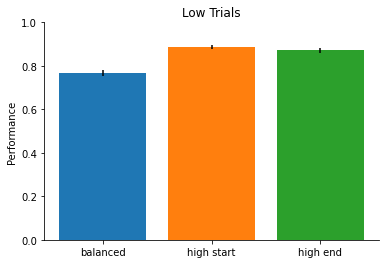

In [124]:
for i in range(3):
    plt.bar(x=i, height=results_array_low[i,0], yerr=results_array_low[i,2]-results_array_low[i,0])

plt.xticks(np.arange(3), ['balanced', 'high start', 'high end'])
plt.title('Low Trials')
plt.ylabel('Performance')
plt.ylim(0,1)
sns.despine()
plt.show()

In [74]:
pg.compute_bootci(x=df_balanced_low['Correct'], func='mean', method='cper', confidence=.95, n_boot = 2000, decimals = 3, seed=123)

array([0.809, 0.831])

In [75]:
pg.compute_bootci(x=df_imbalanced_low_l_end['Correct'], func='mean', method='cper', confidence=.95, n_boot = 2000, decimals = 3, seed=123)

array([0.862, 0.889])

In [76]:
pg.compute_bootci(x=df_imbalanced_low_h_end['Correct'], func='mean', method='cper', confidence=.95, n_boot = 2000, decimals = 3, seed=123)

array([0.858, 0.885])

In [60]:
correct_t = df_balanced['Reward_side'] == df_balanced['Choice']
print(correct_t)
perf = correct_t.sum()/len(df_balanced)
print(perf)

0         True
5        False
6         True
7         True
14        True
         ...  
20072     True
20074     True
20082    False
20088    False
20092    False
Length: 4922, dtype: bool
0.8283218203982121


In [64]:
df_imbalanced

,Animal,Window,Date,Difficulty,Session,Trial,Reward_side,Choice,Total Pulse,Pulses_bin_1,Pulses_bin_2,Total Signal,Rel1,Rel2
21,Banner,5000,20220305,3.0,1,21,1,1,12.0,0.046643,0.139929,0.186572,25.000000,75.000000
69,Banner,5000,20220305,3.0,2,16,1,1,15.0,0.063909,0.157103,0.221012,28.916728,71.083272
131,Banner,5000,20220305,3.0,3,12,1,1,14.0,0.062191,0.155476,0.217667,28.571429,71.428571
209,Banner,5000,20220313,3.0,0,16,1,1,12.0,0.031095,0.139976,0.171071,18.176774,81.823226
218,Banner,5000,20220313,3.0,0,25,1,1,18.0,0.077738,0.199066,0.276804,28.084177,71.915823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19977,Tabby,5000,20190519,3.0,0,134,1,1,12.0,0.046643,0.139929,0.186572,25.000000,75.000000
19990,Tabby,5000,20190519,3.0,0,147,1,1,12.0,0.046643,0.124996,0.171639,27.174955,72.825045
20003,Tabby,5000,20190519,3.0,0,160,1,1,11.0,0.046643,0.124379,0.171022,27.273049,72.726951
20005,Tabby,5000,20190519,3.0,0,162,1,1,11.0,0.046643,0.123757,0.170400,27.372561,72.627439


In [65]:
correct_t2 = df_imbalanced['Reward_side'] == df_imbalanced['Choice']
perf2 = correct_t2.sum()/len(df_imbalanced)
print(perf2)

0.8080536912751678


In [539]:
df_reorganized.to_csv('different_contrast_windows_output_updated_2.csv', index=False)


In [99]:
df_2 = df_all.loc[(df_all['Difficulty']==2)]#&(df_all['Total Pulse']<5)|(df_all['Total Pulse']>10)]# & (df_all['Animal']=='Banner')]
df_3 = df_all.loc[(df_all['Difficulty']==3)]#&(df_all['Total Pulse']<5)|(df_all['Total Pulse']>10)]# & (df_all['Animal']=='Banner')]
df_4 = df_all.loc[(df_all['Difficulty']==4)]#&(df_all['Total Pulse']<5)|(df_all['Total Pulse']>10)]# & (df_all['Animal']=='Banner')]
df_6 = df_all.loc[(df_all['Window']==1250)]#&(df_all['Total Pulse']<5)|(df_all['Total Pulse']>10)]# & (df_all['Animal']=='Banner')]
#df_2.loc[df_2['Total Pulse']==10]
#df_2[(df_2['Total Pulse'] >18)]

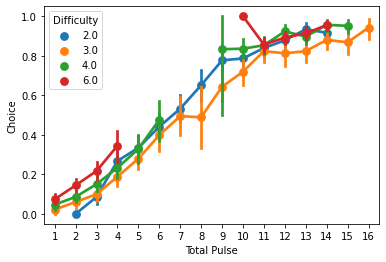

In [100]:
ax = sns.pointplot(x='Total Pulse', y='Choice', hue='Difficulty', data=df_6)
#plt.plot(clip_on=False)

#plt.xticks =np.arange(0,20)
#plt.xlim(0,19)
#plt.ylim(0,1)
#sns.despine(offset=10)

for line in ax.lines:
    line.set_clip_on(False)

In [94]:
df_all['Animal'].unique()

array(['Banner', 'Natasha', 'Peterparker', 'Stark', 'Bengal', 'Shorthair',
       'Tabby'], dtype=object)

[ 1250  2500  5000 10000]


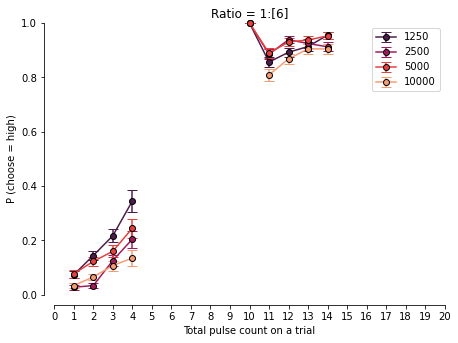

In [89]:
cmap = sns.color_palette('rocket', 4)
windows = np.sort(df_6['Window'].unique())
print(windows)

plt.figure(figsize=(7,5))

for color, window in zip(range(len(cmap)), windows):
    subset = df_6[df_6['Window'] == window]

    grouped = subset.groupby('Total Pulse')['Choice'].agg(['mean', 'count'])



    # Calculate the standard error for each group
    grouped['std_err'] = np.sqrt(grouped['mean'] * (1 - grouped['mean']) / grouped['count'])

    # Reindex to cover the full range and fill missing data with NaN
    grouped = grouped.reindex(np.arange(1, 20))

    # Extract the values for plotting
    B_values = grouped.index.values
    proportions = grouped['mean'].values
    std_err = grouped['std_err'].values


    # Plot using plt.errorbar
    plt.errorbar(B_values, proportions, yerr=std_err, fmt='o-', color=cmap[color], 
                 markeredgecolor='k', ecolor=cmap[color], capsize=5, clip_on=False)
    plt.legend(windows)
    

plt.xticks(np.arange(0,21))
plt.xlim(0,20)
plt.ylim(0,1)
plt.ylabel('P (choose = high)')
plt.xlabel('Total pulse count on a trial')
plt.title('Ratio = 1:'+str((df_6['Difficulty'].unique().astype(int))))
sns.despine(offset=10)
plt.show()

<AxesSubplot:xlabel='Total Pulse', ylabel='Count'>

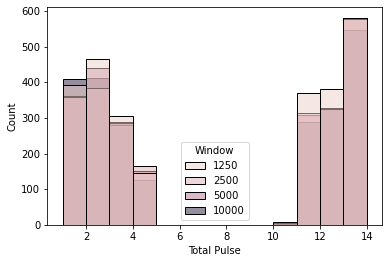

In [90]:
sns.histplot(data=df_6, x='Total Pulse', hue='Window',binwidth=1)

In [235]:
df_mid = df_all.loc[(df_all['Total Pulse']>1) & (df_all['Total Pulse']<5)]# & (df_all['Animal']=='Shorthair')]# & (df_all['Window']==10000)]# & (df_all['Window']==5000)]# & 
#df_5_3['Correct'] = 1*(df_5_3['Reward_side'] == df_5_3['Choice'].astype(int))
#df_5_3.insert(7, 'Correct', df_5_3.pop('Correct'))
#df_5_3.loc[df_5_3['Total Pulse']==4]
#df_low_c['Difficulty'].unique()
type(df_mid

,Animal,Window,Difficulty,Session,Trial,Reward_side,Choice,Total Pulse,Pulses_bin_1,Pulses_bin_2,Pulses_bin_3,Pulses_bin_4,Pulses_bin_5
4,Banner,5000,3.0,1,4,0,0,3,-0.456321,-0.759251,-0.492053,-0.493528,-0.760365
10,Banner,5000,3.0,1,10,0,0,4,-0.761732,-0.490361,0.047734,-0.762171,-0.760365
20,Banner,5000,3.0,1,20,0,0,3,-0.761732,-0.490361,-0.494728,-0.759508,-0.491937
22,Banner,5000,3.0,1,22,0,1,3,-0.456321,-0.490361,-0.761946,-0.493528,-0.760365
23,Banner,5000,3.0,1,23,0,0,3,-0.761732,-0.224282,-0.759126,-0.762171,-0.491937
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46274,Stark,1250,6.0,2,153,0,0,3,-0.761732,0.210758,-0.656002,0.306496,0.319247
46280,Stark,1250,6.0,2,159,0,0,4,-0.260298,-0.125164,-0.761946,0.516229,1.177160
46282,Stark,1250,6.0,2,161,0,0,2,0.458092,-0.757648,0.295077,-0.739724,-0.760365
46286,Stark,1250,6.0,2,165,0,0,2,-0.761732,-0.759251,-0.761946,0.312399,0.262829


In [16]:
df_all

,Animal,Window,Date,Session_name,Difficulty,Session,Tial,Reward_side,Choice,Total Pulse,Pulses_bin_1,Pulses_bin_2,Pulses_bin_3,Pulses_bin_4,Pulses_bin_5
0,Banner,5000,20220305,Banner20220305,3.0,1,0,1,1,18,0.210333,0.195853,2.120527,1.477172,2.115012
1,Banner,5000,20220305,Banner20220305,3.0,1,1,1,0,9,0.228862,-0.092779,-0.199678,-1.118015,1.486702
2,Banner,5000,20220305,Banner20220305,3.0,1,2,1,1,18,2.212338,2.137104,0.826543,0.166982,0.832751
3,Banner,5000,20220305,Banner20220305,3.0,1,3,0,0,7,-0.432296,-1.128824,0.179551,-1.118015,1.486702
4,Banner,5000,20220305,Banner20220305,3.0,1,4,0,0,3,-0.432296,-1.128824,-0.467441,-0.475516,-1.129102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20093,Tabby,5000,20190519,Tabby20190519,3.0,0,250,1,0,12,-1.093455,0.177547,2.140353,1.432292,-0.475151
20094,Tabby,5000,20190519,Tabby20190519,3.0,0,251,0,0,4,-0.563622,-0.999083,-0.467441,0.166982,-1.129102
20095,Tabby,5000,20190519,Tabby20190519,3.0,0,252,0,0,3,-1.093455,-0.834869,-0.111617,-0.475516,-1.129102
20096,Tabby,5000,20190519,Tabby20190519,3.0,0,253,1,0,19,2.212338,2.787613,1.476186,1.451134,-1.128241


Choice ~ Pulses_bin_1+Pulses_bin_2+Pulses_bin_3+Pulses_bin_4+Pulses_bin_5 + (Pulses_bin_1+Pulses_bin_2+Pulses_bin_3+Pulses_bin_4+Pulses_bin_5||Animal/Session_name)
Choice ~ I(Pulses_bin_1+Pulses_bin_2+Pulses_bin_3+Pulses_bin_4+Pulses_bin_5) + (I(Pulses_bin_1+Pulses_bin_2+Pulses_bin_3+Pulses_bin_4+Pulses_bin_5)||Animal/Session_name)
Fitting generalized linear model using glmer (family binomial) with Wald confidence intervals...

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: Choice~Pulses_bin_1+Pulses_bin_2+Pulses_bin_3+Pulses_bin_4+Pulses_bin_5+(Pulses_bin_1+Pulses_bin_2+Pulses_bin_3+Pulses_bin_4+Pulses_bin_5||Animal/Session_name)

Family: binomial	 Inference: parametric

Number of observations: 20098	 Groups: {'Session_name:Animal': 86.0, 'Animal': 7.0}

Log-likelihood: -8478.094 	 AIC: 16992.189

Random effects:

                               Name    Var    Std
Session_name.Animal    Pulses_bin_5  0.011  0.106
Session_name.Animal.1  Pulses_bin_4  0.038  0.195
Ses

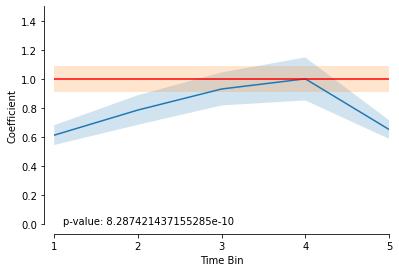

In [85]:
df_sorted = df_all.sort_values(by='Difficulty') #.loc[df_all['Animal']=='Bengal']
df_new, f_vars = df_filter(df_sorted, 5000, 1000) #.loc[df_all['Difficulty']==2.0]
#df_new = df_new.loc[df_new['Difficulty']==3.0]
f_vc, f_sc = formula_maker(f_vars, pred_choice=True, pred_id=False, interaction=False)
print(f"{f_vc}\n{f_sc}")
fig, pval, mvc_df, msc_df, vc_dict, sc_dict = model_fit_compare(df_new, f_vc, f_sc, f_vars, factor='Difficulty')
#print(pval_10000)
# fig.savefig(savepath_svg + 'MMLR_1_25s_C_2_3_BNPS_5bins_ik.svg',transparent=True, format='svg', bbox_inches='tight')
# fig.savefig(savepath_png + 'MMLR_1_25s_C_2_3_BNPS_5bins_ik.png',transparent=True, format='png', bbox_inches='tight')
# fig.savefig(savepath_pdf + 'MMLR_1_25s_C_2_3_BNPS_5bins_ik.pdf',transparent=True, format='pdf', bbox_inches='tight')


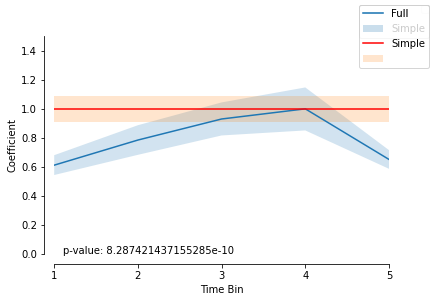

In [91]:
fig.legend(['Full', '', 'Simple', ''])
fig

In [93]:
fig.savefig('MELR_corrected_weight.svg', format='svg', transparent=True, bbox_inches='tight')

In [50]:
print(vc_dict['coef'].values)

vc_dict_corrected = {'vc_coef':vc_dict['coef'].values, 'vc_upper_limit_ci': vc_dict['upper_limit_ci'].values, 'vc_lower_limit_ci': vc_dict['lower_limit_ci'].values}
sc_dict_corrected = {'sc_coef':sc_dict['coef'][0], 'sc_upper_limit_ci': sc_dict['upper_limit_ci'], 'sc_lower_limit_ci': sc_dict['lower_limit_ci']}


[0.48  0.616 0.73  0.784 0.511]


In [51]:
# Combine the dictionaries into a single dictionary
combined_dict = {**vc_dict_corrected, **sc_dict_corrected}

# Save the combined dictionary as a .mat file
scipy.io.savemat('mixed_effects_log_reg_behavior_result.mat', combined_dict)


In [763]:
coeff_array = mvc_df['b'].values/mvc_df['b'].values.max()
print(coeff_array)

[0.6122449  0.78571429 0.93112245 1.         0.65178571]


In [759]:
# Initialize logistic regression model
model = LogisticRegression()

# List to store the results
output = []

# Iterate over each subject and session
for subject in df_all['Animal'].unique()[4:]:
    for session in df_all[df_all['Animal'] == subject]['Date'].unique():
        session_data = df_all[(df_all['Animal'] == subject) & (df_all['Date'] == session)]
        print(subject, session)
        
        # Combine all time bins (early, mid, late) into a single feature matrix
        X = session_data[df_all.columns[8:]].values  # Feature matrix

        y = session_data['Choice'].values  # Targets (binary choice)

               
        # Fit the model
        model.fit(X, y)

        skf = StratifiedKFold(n_splits=5)

        # Perform permutation test score
        score, permutation_scores, p_value = permutation_test_score(
            model, X, y, cv=skf, n_permutations=1000, scoring="accuracy", n_jobs=-1)

        # Number of parameters (including intercept)
        n_params = len(model.coef_.flatten()) + 1  # coefficients + intercept
        # Predicted probabilities for log-likelihood calculation
        y_pred_prob = model.predict_proba(X)
        # Calculate log-likelihood
        log_likelihood = -log_loss(y, y_pred_prob, normalize=False)
        # Compute AIC: 2k - 2 * log-likelihood
        aic = 2 * n_params - 2 * log_likelihood
        #print(f"AIC: {aic}")
        
        # Store the coefficients for each time bin
        output.append({
            'Subject': subject,
            'Date': session,
            #'Date': int(date),
            'Pulses_b0_coef': model.coef_[0][0],
            'Pulses_b1_coef': model.coef_[0][1],
            'Pulses_b2_coef': model.coef_[0][2],
            'Pulses_b3_coef': model.coef_[0][3],
            'Pulses_b4_coef': model.coef_[0][4],
            'intercept': model.intercept_[0],
            'real_accuracy': score,
            'perm_accuracy': np.median(permutation_scores),
            'p_value': p_value,
            'aic': aic})


# Convert results to DataFrame for easy inspection
coefficients_df = pd.DataFrame(output)
coefficients_df

Bengal 20190419


python(32542) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(32543) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(32544) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(32545) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(32546) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(32547) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(32548) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(32549) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Bengal 20190422
Bengal 20190423
Bengal 20190426
Bengal 20190427
Bengal 20190430
Bengal 20190501
Bengal 20190502
Bengal 20190503
Bengal 20190504
Bengal 20190505
Bengal 20190507
Bengal 20190508
Bengal 20190509
Bengal 20190510
Bengal 20190511
Bengal 20190512
Bengal 20190513
Bengal 20190516
Bengal 20190517
Bengal 20190518
Bengal 20190519
Shorthair 20190419
Shorthair 20190422
Shorthair 20190423
Shorthair 20190427
Shorthair 20190430
Shorthair 20190501
Shorthair 20190502
Shorthair 20190503
Shorthair 20190504
Shorthair 20190505
Shorthair 20190507
Shorthair 20190508
Shorthair 20190509
Shorthair 20190516
Shorthair 20190517
Shorthair 20190518
Shorthair 20190519
Tabby 20190419
Tabby 20190423
Tabby 20190426
Tabby 20190427
Tabby 20190430
Tabby 20190501
Tabby 20190503
Tabby 20190504
Tabby 20190505
Tabby 20190510
Tabby 20190511
Tabby 20190512
Tabby 20190513
Tabby 20190514
Tabby 20190516
Tabby 20190517
Tabby 20190518
Tabby 20190519


,Subject,Date,Pulses_b0_coef,Pulses_b1_coef,Pulses_b2_coef,Pulses_b3_coef,Pulses_b4_coef,intercept,real_accuracy,perm_accuracy,p_value,aic
0,Bengal,20190419,0.233728,-0.098451,-0.067098,0.539343,-0.150416,-2.328034,0.758449,0.550041,0.000999,260.868512
1,Bengal,20190422,0.167114,0.263042,0.077966,0.016449,0.322623,-1.892182,0.800000,0.523404,0.000999,233.698516
2,Bengal,20190423,0.249140,-0.105766,0.066245,0.121569,0.525433,-1.478437,0.796723,0.587844,0.000999,202.472302
3,Bengal,20190426,0.158370,0.168687,0.473931,0.317214,0.351396,-0.889592,0.802126,0.549660,0.000999,237.620004
4,Bengal,20190427,0.504069,0.191278,-0.670694,-0.101505,0.216116,-3.976653,0.822727,0.504545,0.000999,179.610719
5,Bengal,20190430,0.430404,-0.248724,-0.272072,0.151897,-0.113838,-3.320249,0.832143,0.544395,0.000999,284.375407
6,Bengal,20190501,0.140186,0.076957,0.419623,0.744785,0.401495,-1.334192,0.839768,0.499927,0.000999,224.997075
7,Bengal,20190502,0.385403,0.174075,0.199756,-0.152334,0.780510,-3.008868,0.880851,0.510638,0.000999,157.048977
8,Bengal,20190503,0.457775,-0.221623,-0.197226,0.609038,0.246065,-3.747050,0.889189,0.516216,0.000999,239.407591
9,Bengal,20190504,0.498423,0.115555,-0.079629,0.195350,0.131480,-3.523799,0.802547,0.561462,0.000999,173.856099


In [760]:
coefficients_df = coefficients_df.rename(columns={
    'intercept': 'intercept_beh',
    'real_accuracy': 'real_accuracy_beh',
    'perm_accuracy': 'perm_accuracy_beh',
    'p_value': 'p_value_beh',
    #'session': 'Date',
    'Subject': 'Animal'})

coefficients_df['Session'] = coefficients_df['Animal'] + str('_') + coefficients_df['Date'] + str('_0')
coefficients_df
#coefficients_df.to_pickle('behavioral_coefficients.pkl')

,Animal,Date,Pulses_b0_coef,Pulses_b1_coef,Pulses_b2_coef,Pulses_b3_coef,Pulses_b4_coef,intercept_beh,real_accuracy_beh,perm_accuracy_beh,p_value_beh,aic,Session
0,Bengal,20190419,0.233728,-0.098451,-0.067098,0.539343,-0.150416,-2.328034,0.758449,0.550041,0.000999,260.868512,Bengal_20190419_0
1,Bengal,20190422,0.167114,0.263042,0.077966,0.016449,0.322623,-1.892182,0.800000,0.523404,0.000999,233.698516,Bengal_20190422_0
2,Bengal,20190423,0.249140,-0.105766,0.066245,0.121569,0.525433,-1.478437,0.796723,0.587844,0.000999,202.472302,Bengal_20190423_0
3,Bengal,20190426,0.158370,0.168687,0.473931,0.317214,0.351396,-0.889592,0.802126,0.549660,0.000999,237.620004,Bengal_20190426_0
4,Bengal,20190427,0.504069,0.191278,-0.670694,-0.101505,0.216116,-3.976653,0.822727,0.504545,0.000999,179.610719,Bengal_20190427_0
5,Bengal,20190430,0.430404,-0.248724,-0.272072,0.151897,-0.113838,-3.320249,0.832143,0.544395,0.000999,284.375407,Bengal_20190430_0
6,Bengal,20190501,0.140186,0.076957,0.419623,0.744785,0.401495,-1.334192,0.839768,0.499927,0.000999,224.997075,Bengal_20190501_0
7,Bengal,20190502,0.385403,0.174075,0.199756,-0.152334,0.780510,-3.008868,0.880851,0.510638,0.000999,157.048977,Bengal_20190502_0
8,Bengal,20190503,0.457775,-0.221623,-0.197226,0.609038,0.246065,-3.747050,0.889189,0.516216,0.000999,239.407591,Bengal_20190503_0
9,Bengal,20190504,0.498423,0.115555,-0.079629,0.195350,0.131480,-3.523799,0.802547,0.561462,0.000999,173.856099,Bengal_20190504_0


In [761]:
beh_df = coefficients_df
beh_df['max_coef_beh'] = np.abs(beh_df[list(beh_df.columns[2:7])]).max(axis=1)
for odor_bin in beh_df.columns[2:7]:
    new_col = 'norm' + odor_bin
    # Relativize each coefficient by dividing it by the maximum coefficient of that session
    beh_df[new_col] = beh_df[odor_bin] / beh_df['max_coef_beh']

beh_df

,Animal,Date,Pulses_b0_coef,Pulses_b1_coef,Pulses_b2_coef,Pulses_b3_coef,Pulses_b4_coef,intercept_beh,real_accuracy_beh,perm_accuracy_beh,p_value_beh,aic,Session,max_coef_beh,normPulses_b0_coef,normPulses_b1_coef,normPulses_b2_coef,normPulses_b3_coef,normPulses_b4_coef
0,Bengal,20190419,0.233728,-0.098451,-0.067098,0.539343,-0.150416,-2.328034,0.758449,0.550041,0.000999,260.868512,Bengal_20190419_0,0.539343,0.433357,-0.182539,-0.124407,1.000000,-0.278888
1,Bengal,20190422,0.167114,0.263042,0.077966,0.016449,0.322623,-1.892182,0.800000,0.523404,0.000999,233.698516,Bengal_20190422_0,0.322623,0.517985,0.815325,0.241662,0.050987,1.000000
2,Bengal,20190423,0.249140,-0.105766,0.066245,0.121569,0.525433,-1.478437,0.796723,0.587844,0.000999,202.472302,Bengal_20190423_0,0.525433,0.474161,-0.201293,0.126077,0.231368,1.000000
3,Bengal,20190426,0.158370,0.168687,0.473931,0.317214,0.351396,-0.889592,0.802126,0.549660,0.000999,237.620004,Bengal_20190426_0,0.473931,0.334163,0.355932,1.000000,0.669327,0.741450
4,Bengal,20190427,0.504069,0.191278,-0.670694,-0.101505,0.216116,-3.976653,0.822727,0.504545,0.000999,179.610719,Bengal_20190427_0,0.670694,0.751563,0.285194,-1.000000,-0.151343,0.322228
5,Bengal,20190430,0.430404,-0.248724,-0.272072,0.151897,-0.113838,-3.320249,0.832143,0.544395,0.000999,284.375407,Bengal_20190430_0,0.430404,1.000000,-0.577885,-0.632132,0.352918,-0.264491
6,Bengal,20190501,0.140186,0.076957,0.419623,0.744785,0.401495,-1.334192,0.839768,0.499927,0.000999,224.997075,Bengal_20190501_0,0.744785,0.188223,0.103328,0.563415,1.000000,0.539076
7,Bengal,20190502,0.385403,0.174075,0.199756,-0.152334,0.780510,-3.008868,0.880851,0.510638,0.000999,157.048977,Bengal_20190502_0,0.780510,0.493784,0.223027,0.255929,-0.195173,1.000000
8,Bengal,20190503,0.457775,-0.221623,-0.197226,0.609038,0.246065,-3.747050,0.889189,0.516216,0.000999,239.407591,Bengal_20190503_0,0.609038,0.751637,-0.363890,-0.323831,1.000000,0.404022
9,Bengal,20190504,0.498423,0.115555,-0.079629,0.195350,0.131480,-3.523799,0.802547,0.561462,0.000999,173.856099,Bengal_20190504_0,0.498423,1.000000,0.231842,-0.159761,0.391936,0.263792


In [762]:
beh_df.to_pickle('behavioral_coefficients.pkl')

In [344]:
df_prueba = df_all.loc[(df_all['Window']==1250)]# & (df_all['Difficulty']==6)]# & (df_all['Animal']=='Peterparker')]
df_prueba

,Animal,Window,Date,Difficulty,Session,Trial,Reward_side,Choice,Total Pulse,Pulses_bin_1,Pulses_bin_2,Pulses_bin_3,Pulses_bin_4,Pulses_bin_5
9571,Banner,1250,20220504,2.0,0,0,1,1,12,1.681560,0.057098,3.238330,3.074890,1.349257
9572,Banner,1250,20220504,2.0,0,1,1,1,14,1.738667,5.299505,2.785355,0.346577,1.333448
9573,Banner,1250,20220504,2.0,0,2,1,1,11,1.115757,0.955001,1.251133,0.444600,3.238620
9574,Banner,1250,20220504,2.0,0,3,1,1,14,4.106134,0.332788,1.019842,3.884302,1.414457
9575,Banner,1250,20220504,2.0,0,4,1,1,11,1.681560,0.318350,1.392915,3.248249,1.553688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46288,Stark,1250,20220512,6.0,2,167,0,1,3,-0.761732,0.297963,0.025297,-0.452867,0.137823
46289,Stark,1250,20220512,6.0,2,168,1,1,13,0.459914,1.364531,2.501292,1.781829,3.184537
46290,Stark,1250,20220512,6.0,2,169,1,0,12,5.226613,1.495813,3.326846,0.542442,-0.760365
46291,Stark,1250,20220512,6.0,2,170,1,1,14,2.844818,2.518721,2.425991,0.829907,2.263597


In [920]:
Lmer(formula = f_vc, family='binomial', data = df_new).fit()

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: Choice~Pulses_bin_1+Pulses_bin_2+Pulses_bin_3+Pulses_bin_4+Pulses_bin_5+(1|Animal:Session)

Family: binomial	 Inference: parametric

Number of observations: 20098	 Groups: {'Animal:Session': 16.0}

Log-likelihood: -8634.092 	 AIC: 17282.185

Random effects:

                       Name  Var    Std
Animal:Session  (Intercept)  0.1  0.317

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.074,-0.095,0.243,0.086,1.077,0.910,1.276,0.519,0.476,0.561,0.864,0.388,
Pulses_bin_1,0.447,0.406,0.488,0.021,1.564,1.501,1.629,0.610,0.600,0.620,21.404,0.000,***
Pulses_bin_2,0.560,0.518,0.602,0.022,1.750,1.678,1.826,0.636,0.627,0.646,25.956,0.000,***
Pulses_bin_3,0.680,0.637,0.724,0.022,1.975,1.890,2.063,0.664,0.654,0.673,30.571,0.000,***
Pulses_bin_4,0.713,0.669,0.756,0.022,2.039,1.952,2.131,0.671,0.661,0.681,31.831,0.000,***
Pulses_bin_5,0.479,0.438,0.520,0.021,1.614,1.549,1.682,0.617,0.608,0.627,22.899,0.000,***


In [761]:
0.600662-0.524510

0.076152

In [823]:
df_sample = df_low_c.sample(n=2500, random_state=99, weights=1/len(df_low_c['Session'].unique()))
test = df_sample.groupby('Animal').sum()
test

ValueError: Weights and axis to be sampled must be of same length

In [28]:
delayt = 10000
binsize = 625
diffic = 3.0

df3 = df_all.loc[(df_all['Window'] == delayt) & (df_all['Difficulty']==diffic)]# & (df2['Contrast'] == 3.0)]
#df3['Difficulty'].unique()
#df3
vars = list(df3.columns[7:])
f_vars = vars[:int(delayt/binsize)]
#ttt = list(df3['Difficulty'].unique().astype(str))
#formula_sep, formula_one_beta = formula_maker(f_vars, pred_choice=True, pred_id=False)
df3

,Animal,Window,Difficulty,Session,Trial,Reward_side,Choice,Pulses_bin_1,Pulses_bin_2,Pulses_bin_3,...,Pulses_bin_7,Pulses_bin_8,Pulses_bin_9,Pulses_bin_10,Pulses_bin_11,Pulses_bin_12,Pulses_bin_13,Pulses_bin_14,Pulses_bin_15,Pulses_bin_16
240,Siamese,10000,3.0,9,0,1,1.0,-0.623856,-0.102289,-0.090497,...,-0.654787,-0.546100,0.457652,-0.644929,0.103928,-0.001640,0.647649,1.251055,1.353004,-0.526876
241,Siamese,10000,3.0,9,1,0,1.0,0.358390,-0.657497,0.291785,...,-0.654787,-0.587087,-0.642983,-0.644929,-0.640205,-0.631477,-0.651237,1.026899,1.376986,1.751279
242,Siamese,10000,3.0,9,2,0,1.0,-0.579557,0.562492,-0.655477,...,0.079747,1.253398,-0.640172,-0.644929,-0.640205,-0.631477,-0.651237,1.156301,-0.091861,-0.526876
243,Siamese,10000,3.0,9,3,0,0.0,-0.627788,-0.663865,-0.514865,...,-0.649844,-0.587087,-0.642983,-0.155693,1.407300,-0.008423,0.628665,-0.628227,-0.646701,-0.526876
244,Siamese,10000,3.0,9,4,0,0.0,-0.624455,1.137036,0.792395,...,-0.654787,-0.587087,-0.642233,-0.518687,-0.629908,-0.629215,-0.651237,-0.628227,-0.646701,-0.067692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6959,Calico,10000,3.0,8,131,0,0.0,-0.627788,-0.508622,-0.413829,...,-0.654787,0.233548,-0.630601,-0.644929,-0.640205,-0.631477,1.312569,-0.628227,-0.646701,-0.526876
6960,Calico,10000,3.0,8,132,1,1.0,-0.627788,-0.663865,0.383172,...,0.264585,0.849731,0.091497,-0.644929,-0.639744,1.264406,-0.645918,3.198452,2.103387,-0.172656
6961,Calico,10000,3.0,8,133,1,0.0,-0.627788,3.210537,-0.502736,...,0.165854,0.737269,-0.642983,-0.644929,-0.023259,-0.631477,-0.651237,1.004875,-0.646701,-0.526805
6962,Calico,10000,3.0,8,134,0,0.0,-0.627788,-0.663865,-0.655477,...,-0.654787,-0.284408,-0.639428,1.569235,-0.640205,1.469620,-0.651237,-0.628227,-0.465211,-0.526876


In [33]:
from patsy import ModelDesc
# m0 = Lmer(formula = 'Choice ~ 1', family='binomial', data = df3)
# m1 = Lmer(formula = 'Choice ~ 1 + Window + (1| Animal) + (1| Session)', family='binomial', data = df2)
# m2 = Lmer(formula = 'Choice ~ Pulses_bin_1 + Pulses_bin_2 + Pulses_bin_3 + Pulses_bin_4 + Pulses_bin_5 + Difficulty + Window + (Difficulty|Animal)', family='binomial', data = df3)
# m3 = Lmer(formula = 'Choice ~ Pulses_bin_1:Difficulty + Pulses_bin_2:Difficulty + Pulses_bin_3:Difficulty + Pulses_bin_4:Difficulty + Pulses_bin_5:Difficulty + Difficulty + (Difficulty|Animal)', family='binomial', data = df3)
m4 = Lmer(formula = formula_sep, family='binomial', data = df3)
m_test = Lmer(formula = formula_one_beta, family='binomial', data = df3)

desc2 = ModelDesc.from_formula(formula_sep)
desc2.describe()

'Choice ~ Pulses_bin_1 + Pulses_bin_2 + Pulses_bin_3 + Pulses_bin_4 + Pulses_bin_5 + Pulses_bin_6 + Pulses_bin_7 + Pulses_bin_8 + Pulses_bin_9 + Pulses_bin_10 + Pulses_bin_11 + Pulses_bin_12 + Pulses_bin_13 + Pulses_bin_14 + Pulses_bin_15 + Pulses_bin_16 + 1 | Animal:Session'

In [34]:
m4.fit(summarize=True, control="optimizer='bobyqa'") #factors={"Difficulty": ['2.0','3.0','4.0','6.0']}, 
#AIC: 2235.683

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: Choice~Pulses_bin_1+Pulses_bin_2+Pulses_bin_3+Pulses_bin_4+Pulses_bin_5+Pulses_bin_6+Pulses_bin_7+Pulses_bin_8+Pulses_bin_9+Pulses_bin_10+Pulses_bin_11+Pulses_bin_12+Pulses_bin_13+Pulses_bin_14+Pulses_bin_15+Pulses_bin_16+(1|Animal:Session)

Family: binomial	 Inference: parametric

Number of observations: 2398	 Groups: {'Animal:Session': 16.0}

Log-likelihood: -1210.646 	 AIC: 2457.292

Random effects:

                       Name    Var    Std
Animal:Session  (Intercept)  0.248  0.498

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.064,-0.329,0.202,0.136,0.938,0.719,1.224,0.484,0.418,0.550,-0.469,0.639,
Pulses_bin_1,0.199,0.093,0.305,0.054,1.220,1.098,1.356,0.550,0.523,0.576,3.686,0.000,***
Pulses_bin_2,0.235,0.132,0.338,0.052,1.265,1.142,1.402,0.559,0.533,0.584,4.485,0.000,***
Pulses_bin_3,0.092,-0.014,0.197,0.054,1.096,0.987,1.217,0.523,0.497,0.549,1.708,0.088,.
Pulses_bin_4,0.161,0.056,0.266,0.054,1.175,1.058,1.305,0.540,0.514,0.566,3.009,0.003,**
Pulses_bin_5,0.212,0.110,0.315,0.052,1.237,1.116,1.370,0.553,0.527,0.578,4.069,0.000,***
Pulses_bin_6,0.219,0.112,0.325,0.054,1.244,1.119,1.384,0.554,0.528,0.581,4.031,0.000,***
Pulses_bin_7,0.168,0.070,0.267,0.050,1.183,1.072,1.306,0.542,0.517,0.566,3.343,0.001,***
Pulses_bin_8,0.213,0.117,0.309,0.049,1.237,1.124,1.361,0.553,0.529,0.577,4.360,0.000,***
Pulses_bin_9,0.237,0.134,0.341,0.053,1.268,1.143,1.406,0.559,0.533,0.584,4.492,0.000,***


In [35]:
m_test.fit(summarize=True, control="optimizer='bobyqa'") #factors={"Difficulty": ['2.0','3.0','4.0','6.0']}, 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: Choice~I(Pulses_bin_1+Pulses_bin_2+Pulses_bin_3+Pulses_bin_4+Pulses_bin_5+Pulses_bin_6+Pulses_bin_7+Pulses_bin_8+Pulses_bin_9+Pulses_bin_10+Pulses_bin_11+Pulses_bin_12+Pulses_bin_13+Pulses_bin_14+Pulses_bin_15+Pulses_bin_16)+(1|Animal:Session)

Family: binomial	 Inference: parametric

Number of observations: 2398	 Groups: {'Animal:Session': 16.0}

Log-likelihood: -1232.769 	 AIC: 2471.539

Random effects:

                       Name    Var    Std
Animal:Session  (Intercept)  0.235  0.485

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.065,-0.324,0.194,0.132,0.937,0.723,1.215,0.484,0.420,0.548,-0.489,0.625,
I(Pulses_bin_1 + Pulses_bin_2 + Pulses_bin_3 + Pulses_bin_4 + Pulses_bin_5 + Pulses_bin_6 + Pulses_bin_7 + Pulses_bin_8 + Pulses_bin_9 + Pulses_bin_10 + Pulses_bin_11 + Pulses_bin_12 + Pulses_bin_13 + Pulses_bin_14 + Pulses_bin_15 + Pulses_bin_16),0.248,0.227,0.268,0.010,1.281,1.255,1.307,0.562,0.557,0.567,23.676,0.000,***


<AxesSubplot:xlabel='Total Pulse', ylabel='Choice'>

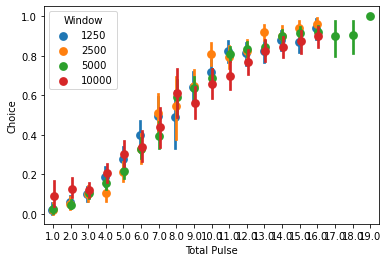

In [199]:
sns.pointplot(data=df_5_3, x='Total Pulse', y='Choice', hue='Window', 
            errorbar=('ci', 95), n_boot=1000, join=False, dodge=True)

In [36]:
outp = m4.confint(f_vars)
outp_test = m_test.confint()
outp_test = outp_test.dropna()


lower_limit = outp['2.5 %']
upper_limit = outp['97.5 %']

lower_limit_test = outp_test['2.5 %'][1]
upper_limit_test = outp_test['97.5 %'][1]




<ErrorbarContainer object of 3 artists>

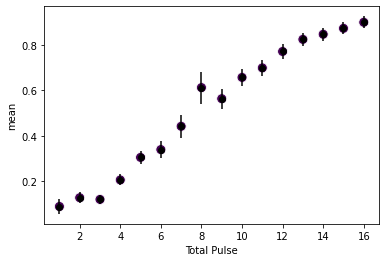

In [154]:
mean_values = df_5_3.groupby(['Total Pulse', 'Window'])['Choice'].agg(['mean', 'sem']).reset_index()

sns.scatterplot(data=mean_values, x='Total Pulse', y='mean', hue='Window', palette='viridis', s=100, legend=False)
plt.errorbar(mean_values['Total Pulse'], mean_values['mean'], yerr=mean_values['sem'], fmt='o', color='black')


([<matplotlib.axis.XTick at 0x15cb03130>], [Text(0, 0, '')])

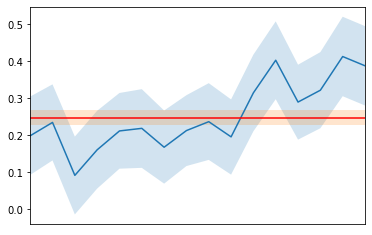

In [38]:
m4_df = result_to_table(m4)
m4_df.head(20)

m4_singleb_df = result_to_table(m_test)
m4_singleb_df.head()

betas = m4_df['b'][:len(f_vars)]
single_beta = m4_singleb_df['b'][0]
plt.plot(betas)
plt.fill_between(range(len(f_vars)), upper_limit, lower_limit, alpha=0.2)
plt.axhline(single_beta, color='r')
plt.fill_between(range(len(f_vars)), upper_limit_test, lower_limit_test, alpha=0.2)
plt.xlim(0,15)
plt.xticks([''])

In [860]:
m4.post_hoc(marginal_vars=['Pulses_bin_4'], grouping_vars='Difficulty')

P-values adjusted by tukey method for family of 6 estimates


(  Difficulty  Estimate  2.5_ci  97.5_ci     SE   DF
 1        2.0     0.453   0.367    0.539  0.044  inf
 2        3.0     0.603   0.503    0.703  0.051  inf
 3        4.0     0.633   0.511    0.755  0.062  inf
 4        6.0     0.751   0.635    0.867  0.059  inf,
                         Contrast  Estimate  2.5_ci  97.5_ci     SE   DF  \
 1  Difficulty2.0 - Difficulty3.0    -0.150  -0.323    0.023  0.067  inf   
 2  Difficulty2.0 - Difficulty4.0    -0.180  -0.376    0.015  0.076  inf   
 3  Difficulty2.0 - Difficulty6.0    -0.298  -0.487   -0.109  0.073  inf   
 4  Difficulty3.0 - Difficulty4.0    -0.030  -0.237    0.176  0.081  inf   
 5  Difficulty3.0 - Difficulty6.0    -0.148  -0.349    0.052  0.078  inf   
 6  Difficulty4.0 - Difficulty6.0    -0.118  -0.338    0.102  0.086  inf   
 
    Z-stat  P-val  Sig  
 1  -2.228  0.116       
 2  -2.371  0.083    .  
 3  -4.058  0.000  ***  
 4  -0.377  0.982       
 5  -1.898  0.229       
 6  -1.374  0.516       )

In [ ]:
marginal_estimates, comparisons = m4.post_hoc(marginal_vars =["Pulses_bin_5"],grouping_vars = ['Difficulty'], summarize=True)

RuntimeError: Model must be fitted to generate post-hoc comparisons

In [690]:
m_varying_coefs.predict()

NameError: name 'm_varying_coefs' is not defined